# 作業
請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響  
常見的 optimizer 包含  
- SGD  
- RMSprop
- AdaGrad
- Adam

今日百日馬拉松作業 : 注意事項

1. 今日作業記憶體需求較大, 請同學執行時記得 shutdown 其他執行中的 .ipynb 檔

2. 提醒同學們今日執行會比較久(幾分鐘到數小時不等)

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
## 超參數設定
LEARNING_RATE = [0.1, 1e-3, 1e-5]
EPOCHS = 30
BATCH_SIZE = 128
MOMENTUM = 0.3

In [7]:
OPTIMIZERS = ['SGD', 'RMSprop', 'AdaGrad', 'Adam']  

results = {}
for opt in OPTIMIZERS:
    for lr in LEARNING_RATE:
        keras.backend.clear_session() 
        print("Optimizer = %s, Learn Rate = %.6f" % (opt, lr))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()

        if (opt == 'Adam'):
            optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
        elif (opt == 'SGD'):
            optimizer = keras.optimizers.SGD(lr=lr, momentum=0.3, decay=0.0, nesterov =True)
        elif (opt == 'RMSprop'):
            optimizer = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)   
        elif (opt == 'AdaGrad'):
            optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)  

        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "%s-%s" % (opt, str(lr))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

W0808 13:55:37.784318 140255005652864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0808 13:55:37.786085 140255005652864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0808 13:55:37.826856 140255005652864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 13:55:37.827824 140255005652864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W080

Optimizer = SGD, Learn Rate = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,640,330
Trainable params: 1,640,330
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 11s 229us/step - loss: 1.9865 - acc: 0.2775 - val_loss: 1.8342 - val_acc: 0.3202
Epoch 2/30
50000/50000 [============

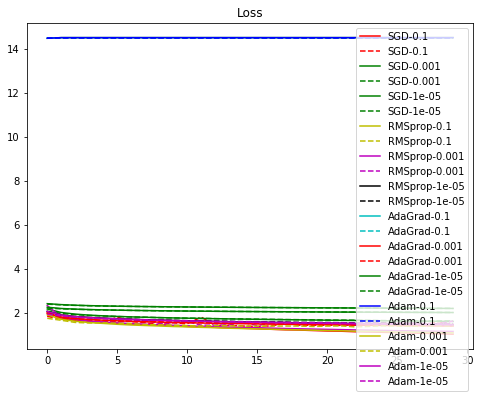

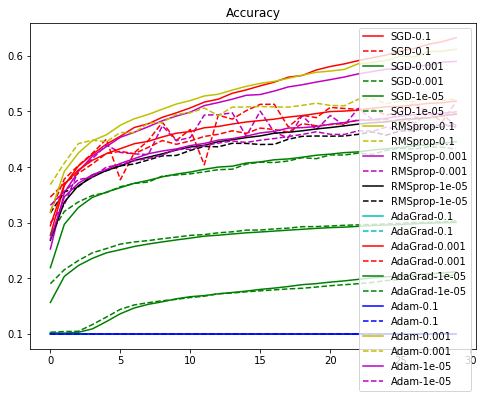

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "g", "y", "m", "k", "c","r", "g", "b", "y", "m"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

參考資料

- [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/)  
- [優化器總結 by Joe-Han](https://blog.csdn.net/u010089444/article/details/76725843)